## Baichuan + Lora + Agent
baichuan-7B是由百川智能开发的一个开源的大规模预训练模型。基于Transformer结构，在大约1.2万亿tokens上训练的70亿参数模型，支持中英双语，上下文窗口长度为4096。在标准的中文和英文权威benchmark（C-EVAL/MMLU）上均取得同尺寸最好的效果。

1. Ref: https://modelscope.cn/models/baichuan-inc/baichuan-7B/summary
2. 以下脚本可以在2*A10环境下正常运行, 大概占用40G显存

### 配置实验环境

In [1]:
# !pip install modelscope
# !pip install numpy pandas matplotlib scikit-learn
# !pip install transformers datasets
# !conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
# !pip install tqdm
# !pip install tensorboard
# !pip install torchmetrics
# 
# !pip install numpy -U  # 解决torchmetrics依赖问题, 更新numpy

In [2]:
from _common import *
device_ids = list(range(min(4, torch.cuda.device_count())))
logger.info(device_ids)
select_device(device_ids)
_ = seed_everything(42)

[2023-07-02 17:24:09,391] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/hackathon/miniconda3/envs/hackathon/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-02 17:24:09,870 - modelscope - INFO - PyTorch version 2.0.1 Found.
2023-07-02 17:24:09,871 - modelscope - INFO - Loading ast index from /home/hackathon/.cache/modelscope/ast_indexer
2023-07-02 17:24:09,895 - modelscope - INFO - Loading done! Current index file version is 1.6.2, with md5 ddf811ee982377c1357284a2bfda3dec and a total number of 861 components indexed
2023-07-02 17:24:10,570 - modelscope - INFO - [0, 1]
2023-07-02 17:24:10,719 - modelscope - INFO - Using device: cuda:0,1
2023-07-02 17:24:10,720 - modelscope - INFO - Global seed set to 42


### 导入Model, Tokenizer

In [3]:
model_id = "baichuan-inc/baichuan-7B"
WORK_DIR = "runs/baichuan"
LORA_TARGET_MODULES = ["W_pack"]
model_dir = get_model_dir(model_id, None)
model, tokenizer = get_baichuan_model_tokenizer(model_dir)
# 
GRADIENT_CHECKPOINTING = True
if GRADIENT_CHECKPOINTING:
    model.gradient_checkpointing_enable()
    model.enable_input_require_grads()
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
# 
logger.info(f"bos_token_id: {tokenizer.bos_token_id}, eos_token_id: {tokenizer.eos_token_id}, "
            f"pad_token_id: {tokenizer.pad_token_id}")

2023-07-02 17:24:11,036 - modelscope - INFO - Model revision not specified, use default: master in development mode
2023-07-02 17:24:11,037 - modelscope - INFO - Development mode use revision: master
2023-07-02 17:24:11,364 - modelscope - INFO - model_config: BaiChuanConfig {
  "architectures": [
    "BaiChuanForCausalLM"
  ],
  "auto_map": {
    "AutoConfig": "configuration_baichuan.BaiChuanConfig",
    "AutoModelForCausalLM": "modeling_baichuan.BaiChuanForCausalLM"
  },
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "model_type": "baichuan",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "pad_token_id": 0,
  "rms_norm_eps": 1e-06,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.30.2",
  "use_cache": true,
  "vocab_size": 64000
}

The model weights are not tied. Please use the `tie_weights` method 

### 准备Lora

In [4]:
LORA_RANK = 8
LORA_ALPHA = 32
LORA_DROPOUT_P = 0.1
lora_config = LoRAConfig(
    replace_modules=LORA_TARGET_MODULES,
    rank=LORA_RANK,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT_P)
logger.info(f"lora_config: {lora_config}")
Swift.prepare_model(model, lora_config)
#
show_freeze_layers(model)
print_model_info(model)
_p = list(model.parameters())[100]
logger.info(f"device: {_p.device}, dtype: {_p.dtype}")
model.bfloat16()

2023-07-02 17:24:21,741 - modelscope - INFO - lora_config: LoRAConfig(rank=8, replace_modules=['W_pack'], lora_alpha=32, lora_dropout=0.1, merge_weights=True, use_merged_linear=False, enable_lora=None, fan_in_fan_out=False, bias='none', only_lora_trainable=True, pretrained_weights=None)
2023-07-02 17:24:36,360 - modelscope - INFO - model.embed_tokens.weight: requires_grad=False
2023-07-02 17:24:36,360 - modelscope - INFO - model.layers.0.self_attn.W_pack.weight: requires_grad=False
2023-07-02 17:24:36,361 - modelscope - INFO - model.layers.0.self_attn.W_pack.lora_A: requires_grad=True
2023-07-02 17:24:36,361 - modelscope - INFO - model.layers.0.self_attn.W_pack.lora_B: requires_grad=True
2023-07-02 17:24:36,361 - modelscope - INFO - model.layers.0.self_attn.o_proj.weight: requires_grad=False
2023-07-02 17:24:36,362 - modelscope - INFO - model.layers.0.mlp.gate_proj.weight: requires_grad=False
2023-07-02 17:24:36,362 - modelscope - INFO - model.layers.0.mlp.down_proj.weight: requires_gr

BaiChuanForCausalLM(
  (model): Model(
    (embed_tokens): Embedding(64000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x DecoderLayer(
        (self_attn): Attention(
          (W_pack): Linear(
            in_features=4096, out_features=12288, bias=False
            (lora_dropout): Dropout(p=0.1, inplace=False)
          )
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): RotaryEmbedding()
        )
        (mlp): MLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=4096, out_features=64000, bias=False)
)

### 导入Dataset

In [5]:
tokenize_function = partial(tokenize_function, tokenizer=tokenizer)
train_dataset = make_dataset("train", tokenize_function)
val_dataset = make_dataset("validation", tokenize_function)
# 数据分析
stat_dataset(train_dataset)
stat_dataset(val_dataset)
data_collate_fn = partial(data_collate_fn, tokenizer=tokenizer)
print_examples(train_dataset[0], tokenizer)

100%|██████████| 285/285 [00:00<00:00, 383.15it/s]
2023-07-02 17:24:49,863 - modelscope - INFO - Dataset Token Length: 958.649707±371.357483, min=44.000000, max=2045.000000, size=4953
2023-07-02 17:24:49,864 - modelscope - INFO - Dataset Token Length: 993.447653±337.821458, min=75.000000, max=1946.000000, size=277


[INPUT_IDS]  你是达摩院的ModelScopeGPT(魔搭助手)，你是个大语言模型， 是2023年达摩院的工程师训练得到的。你有多种能力，可以通过插件集成魔搭社区的模型api来回复用户的问题，还能解答用户使用模型遇到的问题和模型知识相关问答。1. {"plugin_name": "modelscope_text-ie", "plugin_owner": "ModelScopeGPT", "plugin_type": "default", "plugin_schema_for_model": {"name": "modelscope_text-ie", "description": "针对中文的文本，根据schema要抽取的内容，找出其中对应信息，并用json格式展示", "url": "http://109.199.101.10:1485/", "paths": [{"name": "modelscope_text-ie", "model_id": "/damo/nlp_structbert_siamese-uie_chinese-base", "method": "post", "description": "针对中文的文本，根据schema要抽取的内容，找出其中对应信息，并用json格式展示", "parameters": [{"name": "text", "description": "用户输入的文本", "required": "True"}, {"name": "schema", "description": "要抽取信息的json表示", "required": "True"}]}]}}

2. {"plugin_name": "modelscope_text-ie", "plugin_owner": "ModelScopeGPT", "plugin_type": "default", "plugin_schema_for_model": {"name": "modelscope_text-ie", "description": "针对中文的文本，根据schema要抽取的内容，找出其中对应信息，并用json格式展示", "url": "http://9.32.64.200:5873/", "paths": [{"name": "models

### 配置Config

In [6]:
cfg_file = os.path.join(model_dir, "configuration.json")
# 
GRADIENT_CHECKPOINTING = True
BATCH_SIZE = 1
MAX_EPOCHS = 1
T_max = get_T_max(len(train_dataset), BATCH_SIZE, MAX_EPOCHS, True)
WORK_DIR = get_work_dir(WORK_DIR)
EVAL_INTERVAL = 200
CONFIG =  Config({
    "train": {
        "dataloader": {
            "batch_size_per_gpu": BATCH_SIZE,
            "workers_per_gpu": 1,
            "shuffle": True,
            "drop_last": True,
            "pin_memory": True
        },
        "max_epochs": MAX_EPOCHS,
        "work_dir": WORK_DIR,
        "optimizer": {
            "type": "AdamW",
            "lr": 1e-4, 
            "weight_decay": 0.01,
            "options": {
                "cumulative_iters": 16, "grad_clip": {
                    "norm_type": 2,
                    "max_norm": 2.0
                }
            }
        },
        "lr_scheduler": {
            "type": "CosineAnnealingLR",
            "T_max": T_max,
            "eta_min": 1e-5,
            "options": {
                "by_epoch": False,
                "warmup": {
                    'type': 'LinearWarmup',
                    'warmup_ratio': 0.1,
                    "warmup_iters": 200
                }
            }
        },
        "hooks": [
            {"type": "CheckpointHook", "by_epoch": False, "interval": EVAL_INTERVAL,  "max_checkpoint_num": 1},
            {"type": "EvaluationHook", "by_epoch": False, "interval": EVAL_INTERVAL},
            {"type": "BestCkptSaverHook", 
                "metric_key": "acc",   
                "save_best": True, "rule": "max", "max_checkpoint_num": 1},
            {"type": "TextLoggerHook", 
                "by_epoch": True,  # Whether EpochBasedTrainer is used
                "interval": 5,
            },
            {"type": "TensorboardHook", "by_epoch": False, "interval": 5}
        ]
    },
    "evaluation": {
        "dataloader": {
            "batch_size_per_gpu": BATCH_SIZE,
            "workers_per_gpu": 1,
            "shuffle": False,
            "drop_last": False,
            "pin_memory": True
        },
        "metrics": [
            {"type": "my_metric", "vocab_size": tokenizer.vocab_size}
        ]
    }
})


2023-07-02 17:24:49,892 - modelscope - INFO - work_dir: /home/hackathon/my_git/agent/runs/baichuan/v10-20230702-172449


### 微调

In [7]:
def cfg_modify_fn(cfg: Config) -> Config:
    cfg.update(CONFIG)
    return cfg

trainer = EpochBasedTrainer(
    model=model,
    cfg_file=cfg_file,
    data_collator=data_collate_fn,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    remove_unused_data=True,
    seed = 42,
    device='cpu',  # No placement for model, leave the model to `device_map`
    cfg_modify_fn=cfg_modify_fn,
)

trainer.train()

2023-07-02 17:24:49,903 - modelscope - INFO - ==========================Training Config Start==========================
2023-07-02 17:24:49,904 - modelscope - INFO - {
    "framework": "pytorch",
    "task": "text-generation",
    "model": {
        "type": "Baichuan-7B"
    },
    "pipeline": {
        "type": "Baichuan-7B-text-generation-pipe"
    },
    "allow_remote": true,
    "train": {
        "hooks": [
            {
                "type": "TensorboardHook",
                "by_epoch": false,
                "interval": 5
            }
        ],
        "dataloader": {
            "batch_size_per_gpu": 1,
            "workers_per_gpu": 1,
            "shuffle": true,
            "drop_last": true,
            "pin_memory": true
        },
        "max_epochs": 1,
        "work_dir": "/home/hackathon/my_git/agent/runs/baichuan/v10-20230702-172449",
        "optimizer": {
            "type": "AdamW",
            "lr": 0.0001,
            "weight_decay": 0.01,
            "optio

### 可视化
tensorboard 命令: `tensorboard --logdir /home/hackathon/my_git/agent/runs/baichuan/v10-20230702-172449 --port 6006`

dict_keys(['lr', 'loss', 'evaluation/acc', 'evaluation/loss'])


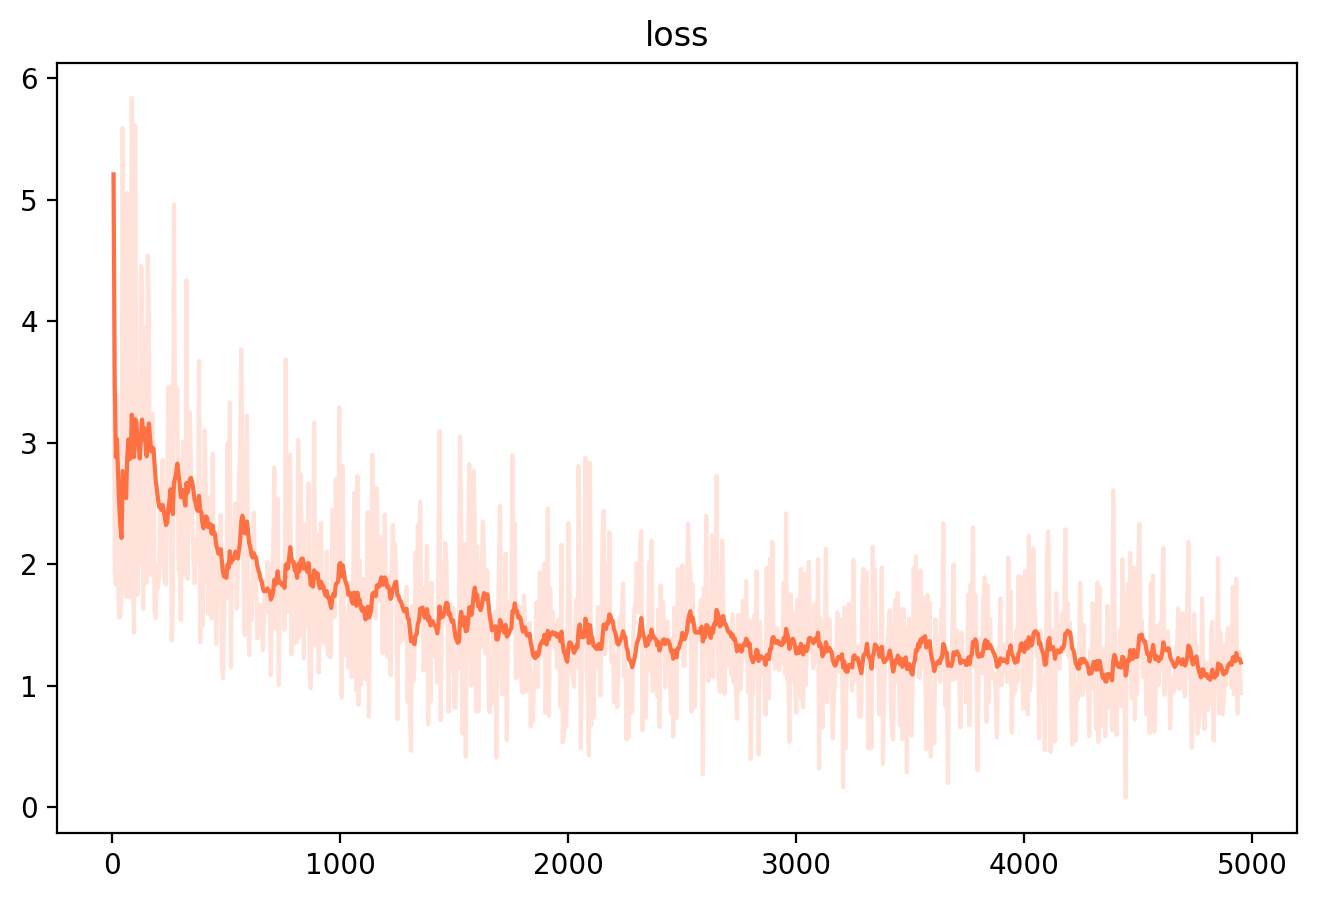

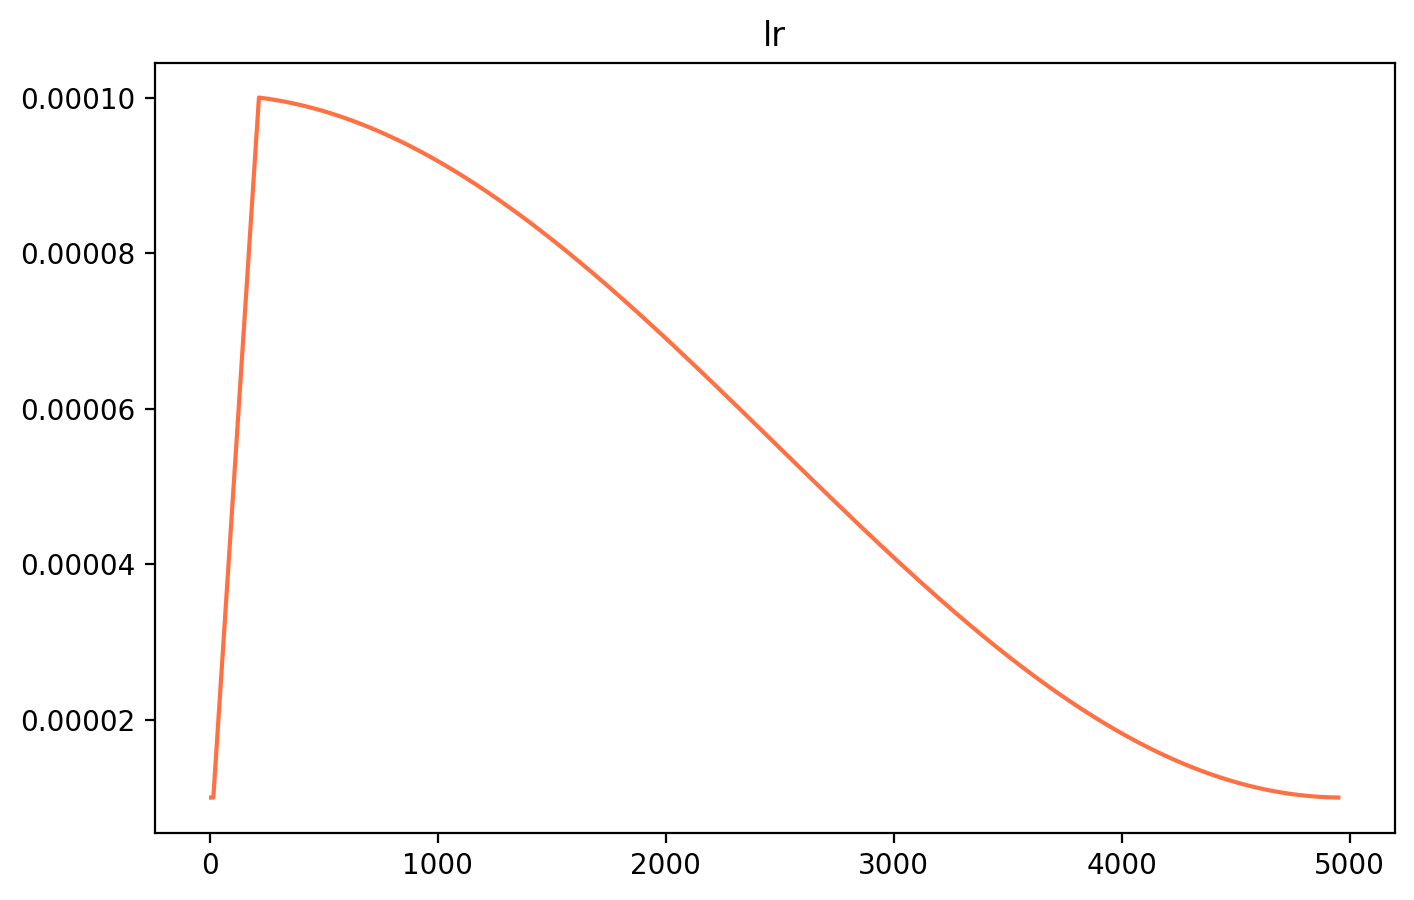

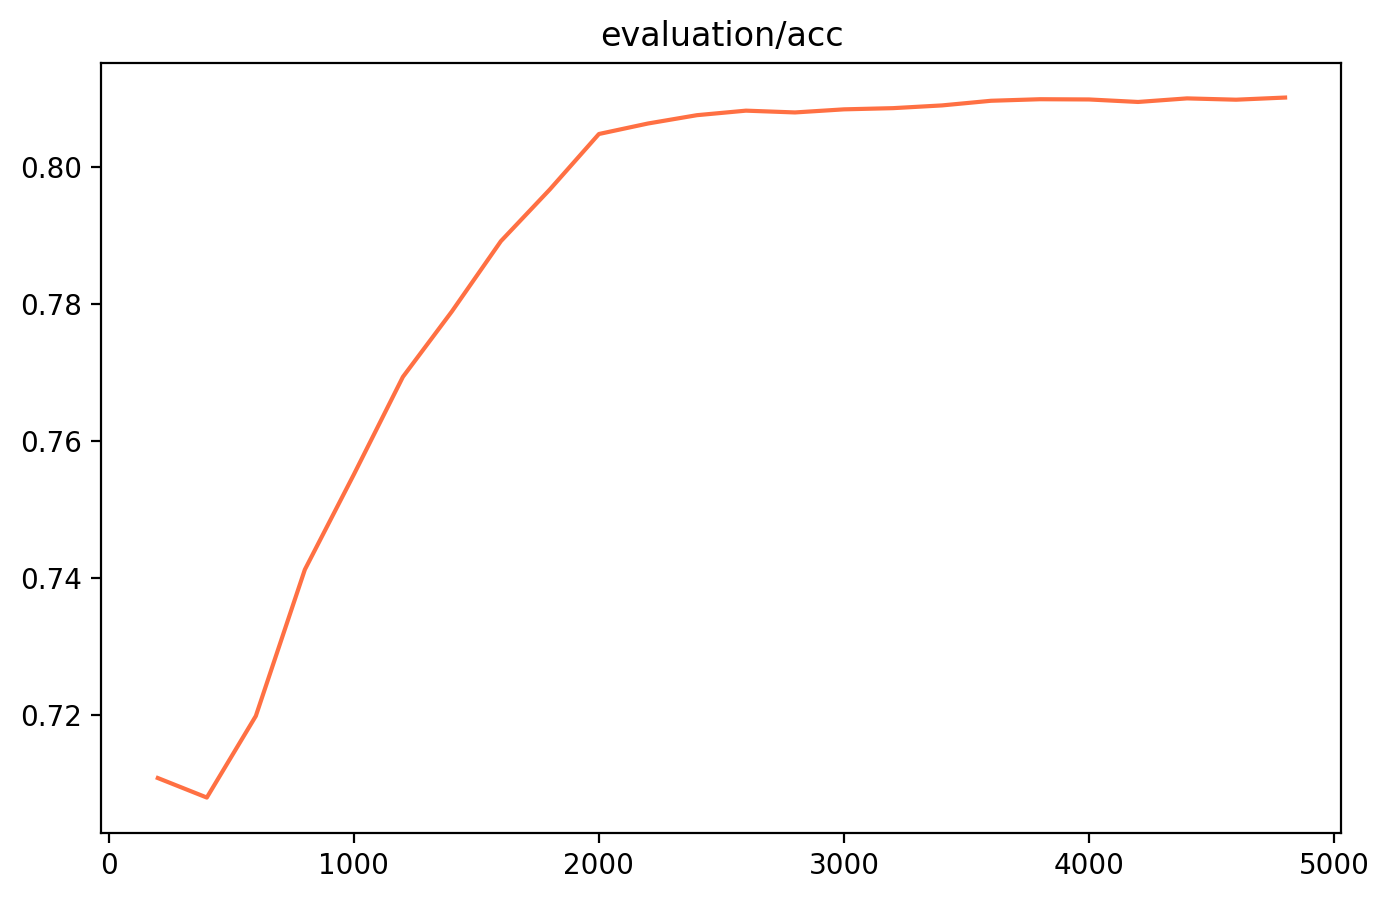

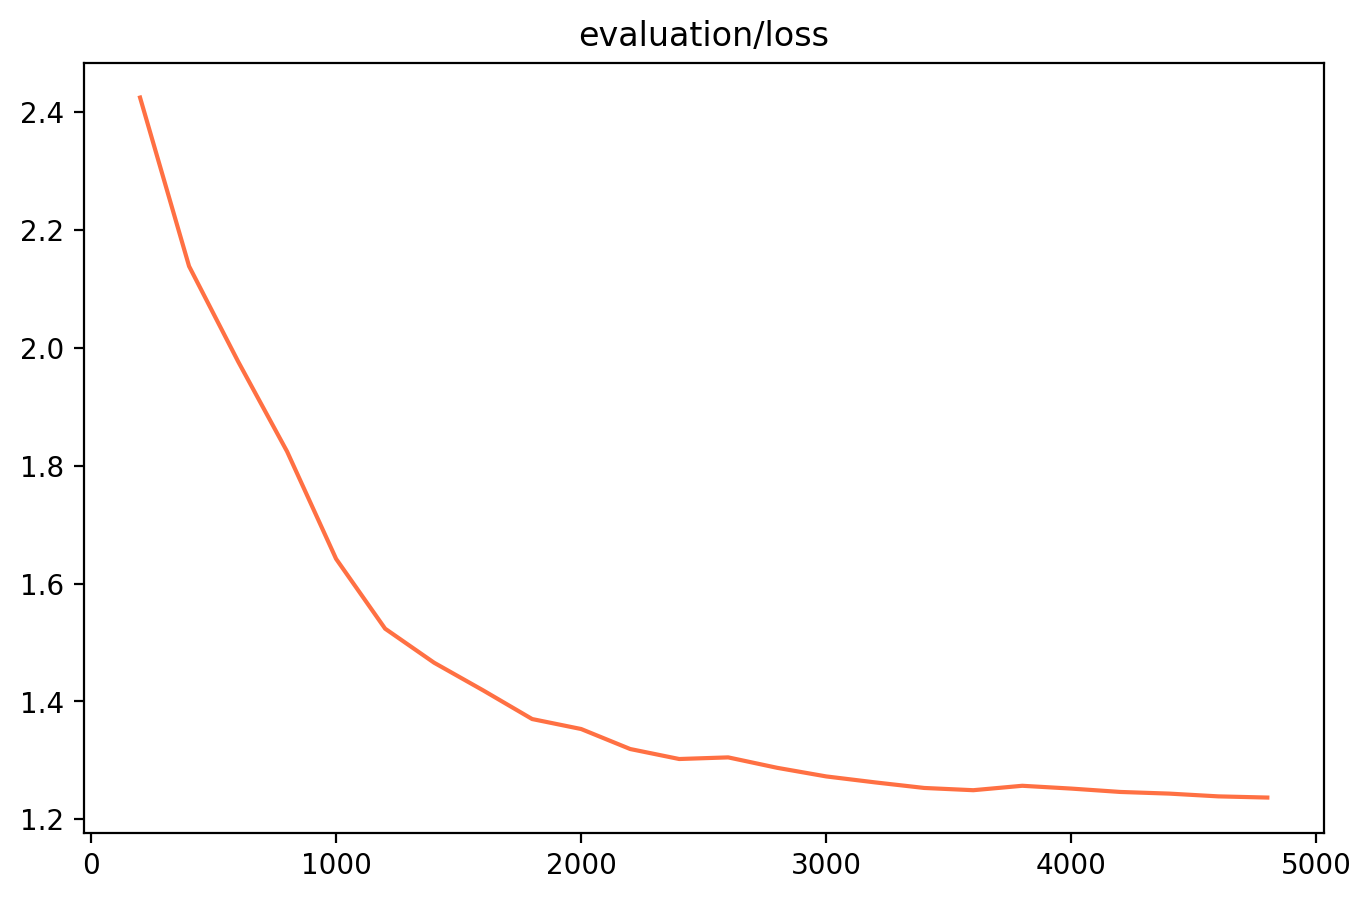

In [8]:
tb_dir = os.path.join(WORK_DIR, "tensorboard_output")
fname = os.listdir(tb_dir)[0]
tb_path = os.path.join(tb_dir, fname)
# 
data = read_tensorboard_file(tb_path)
print(data.keys())
_ = plot_image(data, "loss", 0.9)
_ = plot_image(data, "lr", 0)
_ = plot_image(data, "evaluation/acc", 0)
_ = plot_image(data, "evaluation/loss", 0)

### 推理
推理部分见baichuan_infer.ipynb